# electricity_market_player

> This module training optimizing and evaluation of RL agent on the electricity market environment.
using PPO with actions mask.

In [ ]:
#| default_exp electricity_market_player

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from abc import ABC
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns

from sb3_contrib import MaskablePPO, QRDQN
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.evaluation import evaluate_policy as maskable_evaluate_policy
from scipy import stats
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy as non_maskable_evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from rliable import metrics, plot_utils, library as rly

from electricity_market.electricity_market_env import ElectricityMarketEnv


In [ ]:
#| export
TOTAL_TIMESTEPS = 100 # 100_000
N_EPISODES = 10
N_TRAILS = 10
N_JOBS = 7
seeds = [123456] #, 234567, 345678, 456789, 567890]
if TOTAL_TIMESTEPS % N_EPISODES != 0:
    raise ValueError("Total_timesteps must be a multiple of n_episodes")
frames = np.array(list(range(TOTAL_TIMESTEPS // N_EPISODES, TOTAL_TIMESTEPS + 1, TOTAL_TIMESTEPS // N_EPISODES)), dtype=int)

# Decided On granularity of 100 Wh
env_config = {
    "max_timestep": TOTAL_TIMESTEPS,
}
results = {}

In [ ]:
#| export
class Agent(ABC):
    def __init__(self):
        pass

    @classmethod
    def mask_fn(cls, env: ElectricityMarketEnv) -> np.ndarray:
        return env.action_masks()

    @classmethod
    def collect_episodes_rewards(
            cls,
            model: BaseAlgorithm | None,
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False
    ) -> list[float]:
        raise NotImplementedError

    @classmethod
    def evaluate_policy(
            cls, hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        raise NotImplementedError

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError



In [ ]:
class MaskableRandomAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: BaseAlgorithm,  # Unused for a random agent
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False
    ) -> list[float]:
        episode_rewards = []

        for _ in range(n_episodes):
            obs, _ = env.reset()
            done = False
            total_reward = 0.0

            while not done:
                action_mask = env.action_masks()
                valid_actions = np.where(action_mask)[0]  # Get valid actions
                action = np.random.choice(valid_actions)  # Select random valid action

                obs, reward, done, truncated, _ = env.step(action)
                total_reward += reward
                if truncated:
                    break

            episode_rewards.append(total_reward)

        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        all_rewards = []

        for seed in seeds:
            print(f"\nRunning random agent with seed {seed}...")
            env = ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn)

            seed_rewards = []

            for frame in frames:
                print(f"  Evaluating at {frame} timesteps...")
                rewards = cls.collect_episodes_rewards(None, env, n_episodes, deterministic=True, render=render)
                seed_rewards.append(rewards)

            seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)

        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError


In [ ]:
#| export
class MaskablePPOAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: MaskablePPO,
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False
    ) -> list[float]:
        episode_rewards, _ = maskable_evaluate_policy(
            model, env, deterministic=deterministic, use_masking=True,
            return_episode_rewards=True, n_eval_episodes=n_episodes, render=render
        )
        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        if hyperparameters is None:
            hyperparameters = {}
        all_rewards = []

        for seed in seeds:
            print(f"\nRunning experiment with seed {seed}...")
            env = DummyVecEnv([
                lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn))
            ])

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                verbose=0,
                seed=seed,
                **hyperparameters
            )
            seed_rewards = []

            for frame in frames:
                model.learn(
                    total_timesteps=frame, use_masking=True, reset_num_timesteps=False
                )
                rewards = cls.collect_episodes_rewards(
                    model, env,
                    n_episodes=n_episodes, deterministic=True, render=render
                )
                seed_rewards.append(rewards)

            seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)
        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        global seeds
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        n_steps = trial.suggest_int('n_steps', 32, 1024, log=True)
        batch_size = trial.suggest_int('batch_size', 16, 256, log=True)
        gamma = trial.suggest_float('gamma', 0.9, 0.9999)
        gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
        ent_coef = trial.suggest_float('ent_coef', 0.0, 0.02)
        vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
        clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
        max_grad_norm = trial.suggest_float('max_grad_norm', 0.1, 1.0)

        trial_seed_rewards = []

        for seed in seeds:
            env = DummyVecEnv([
                lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), maskable_ppo_agent.mask_fn))
            ])

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                gamma=gamma,
                gae_lambda=gae_lambda,
                ent_coef=ent_coef,
                vf_coef=vf_coef,
                clip_range=clip_range,
                max_grad_norm=max_grad_norm,
                verbose=0,
                seed=seed
            )

            model.learn(total_timesteps=TOTAL_TIMESTEPS, use_masking=True)
            episode_rewards = cls.collect_episodes_rewards(model, env, n_episodes=n_episodes, deterministic=True, render=False)

            seed_avg_reward = np.mean(episode_rewards)
            trial_seed_rewards.append(seed_avg_reward)
        aggregated_performance = stats.trim_mean(trial_seed_rewards, proportiontocut=0.25)

        return aggregated_performance



In [ ]:
#| export
class QRDQNAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: QRDQN,
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False
    ) -> list[float]:
        episode_rewards, _ = non_maskable_evaluate_policy(
            model, env, deterministic=deterministic,
            return_episode_rewards=True, n_eval_episodes=n_episodes, render=render
        )
        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        if hyperparameters is None:
            hyperparameters = {}
        all_rewards = []

        for seed in seeds:
            print(f"\nRunning experiment with seed {seed}...")
            env = DummyVecEnv([
                lambda: Monitor(ElectricityMarketEnv(env_config, render_mode="human"))
            ])

            model = QRDQN(
                "MlpPolicy",
                env,
                verbose=0,
                seed=seed,
                **hyperparameters
            )
            seed_rewards = []

            for frame in frames:
                print(f"  Training for {frame} timesteps...")
                model.learn(total_timesteps=frame, reset_num_timesteps=False)

                rewards = cls.collect_episodes_rewards(
                    model, env,
                    n_episodes=n_episodes, deterministic=True, render=render
                )
                seed_rewards.append(rewards)

            seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)
        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        global seeds

        # Hyperparameter tuning using Optuna
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        batch_size = trial.suggest_int('batch_size', 16, 256, log=True)
        gamma = trial.suggest_float('gamma', 0.9, 0.9999)
        exploration_fraction = trial.suggest_float('exploration_fraction', 0.1, 0.5)
        exploration_final_eps = trial.suggest_float('exploration_final_eps', 0.01, 0.1)
        target_update_interval = trial.suggest_int('target_update_interval', 100, 10000, log=True)

        trial_seed_rewards = []

        for seed in seeds:
            env = DummyVecEnv([
                lambda: Monitor(ElectricityMarketEnv(env_config, render_mode="human"))
            ])

            model = QRDQN(
                "MlpPolicy",
                env,
                learning_rate=learning_rate,
                batch_size=batch_size,
                gamma=gamma,
                exploration_fraction=exploration_fraction,
                exploration_final_eps=exploration_final_eps,
                target_update_interval=target_update_interval,
                verbose=0,
                seed=seed
            )

            model.learn(total_timesteps=TOTAL_TIMESTEPS)
            episode_rewards = cls.collect_episodes_rewards(model, env, n_episodes=n_episodes, deterministic=True, render=False)

            seed_avg_reward = np.mean(episode_rewards)
            trial_seed_rewards.append(seed_avg_reward)

        # Trimmed mean to avoid outliers affecting optimization
        aggregated_performance = stats.trim_mean(trial_seed_rewards, proportiontocut=0.25)

        return aggregated_performance


In [ ]:
#| export
def plot_evaluation_results(evaluation_results: dict) -> None:
    global seeds, frames, env_config
    # Extract algorithm names (which are actually keys in the dictionary)
    algorithms = list(evaluation_results.keys())

    # Function to compute aggregate metrics (median, IQM, mean) for each checkpoint and seed
    def aggregate_func(x):
        return np.array([
            metrics.aggregate_median(x),
            metrics.aggregate_iqm(x),
            metrics.aggregate_mean(x)
        ], dtype=np.float64)

    # For each algorithm, we need to apply aggregate_func to the data (which has the shape (num_seeds, num_checkpoints, num_episodes))
    def aggregate_over_checkpoints(evaluation_results):
        aggregated_results = {}
        for algorithm, results in evaluation_results.items():
            # results.shape is (num_seeds, num_checkpoints, num_episodes)
            # We aggregate across seeds and episodes for each checkpoint
            agg_results = np.array([aggregate_func(results[:, i, :]) for i in range(results.shape[1])])
            aggregated_results[algorithm] = agg_results
        return aggregated_results

    # Aggregate results across seeds and episodes
    aggregated_results = aggregate_over_checkpoints(evaluation_results)

    # Use rly to compute interval estimates
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        aggregated_results, aggregate_func, reps=50000
    )

    # Plot aggregate metrics (Median, IQM, Mean)
    metric_names = ['Median', 'IQM', 'Mean']
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=metric_names,
        algorithms=algorithms,
        xlabel='Reward'
    )
    fig.set_size_inches(10, 5)
    plt.suptitle("Aggregate Metrics with 95% Stratified Bootstrap CIs", y=1.05, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

    # =============================================================================
    # 2. Probability of Improvement (if comparing two algorithms)
    # =============================================================================

    for alg1, alg2 in combinations(algorithms, 2):
        algorithm_pairs = {f"{alg1},{alg2}": (evaluation_results[alg1], evaluation_results[alg2])}

        average_probabilities, average_prob_cis = rly.get_interval_estimates(
            algorithm_pairs, metrics.probability_of_improvement, reps=2000
        )

        plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)
        plt.title(f"Probability of Improvement: {alg1} vs {alg2}", pad=20)
        plt.show()

    # =============================================================================
    # 3. Sample Efficiency Curve (using frames as defined in the evaluation function)
    # =============================================================================
    sample_efficiency_dict = {
        alg: results[:, :, :]
        for alg, results in evaluation_results.items() if len(results.shape) == 3
    }

    # Define the IQM function
    iqm_func = lambda scores: np.array([metrics.aggregate_iqm(scores[:, :, frame]) for frame in range(scores.shape[2])])

    # Compute IQM scores and confidence intervals using rly
    iqm_scores, iqm_cis = rly.get_interval_estimates(sample_efficiency_dict, iqm_func, reps=50000)
    # Plot the sample efficiency curve
    plot_utils.plot_sample_efficiency_curve(
        frames=frames + 1,  # Adjust frames if necessary
        point_estimates=iqm_scores,
        interval_estimates=iqm_cis,
        algorithms=sample_efficiency_dict.keys(),
        xlabel='Number of Frames',
        ylabel='IQM Reward'
    )
    plt.title("Sample Efficiency Curve")
    plt.show()


    # =============================================================================
    # 4. Performance Profiles (linear and non-linear scaling)
    # =============================================================================
    thresholds = np.linspace(0.0, 8.0, 81)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        evaluation_results, thresholds
    )

    # Plot performance profiles with linear scale
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    plt.title("Performance Profiles (Linear Scale)")
    plt.show()

    # Plot performance profiles with non-linear scaling
    thresholds = np.logspace(-1, 0, num=50)
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        use_non_linear_scaling=True,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    # ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.title("Performance Profiles (Non-Linear Scaling)")
    plt.tight_layout()
    plt.show()

    # =============================================================================
    # 5. Learning Curves (One plot for all algorithms)
    # =============================================================================
    plt.figure(figsize=(12, 8))

    for algorithm in algorithms:
        results = evaluation_results[algorithm]

        cumulative_rewards = []

        for index, frame in enumerate(frames):
            cumulative_sum = np.sum(results[:, :index+1, :], axis=1)
            cumulative_mean = np.mean(cumulative_sum)
            cumulative_rewards.append(cumulative_mean)

        cumulative_rewards = np.array(cumulative_rewards)
        plt.plot(frames, cumulative_rewards, label=algorithm, marker='o', markersize=5, linestyle='-')

    # Customize the plot
    plt.xlabel('Frames (Cumulative Timesteps)')
    plt.ylabel('Mean Reward')
    plt.title('Learning Curves of Multiple Algorithms with Confidence Intervals')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
#| export
qrdqn_agent = QRDQNAgent()
maskable_random_agent = MaskableRandomAgent()
maskable_ppo_agent = MaskablePPOAgent()

### Evaluation MaskableRandom on ElectricityMarketEnv


In [ ]:
#| export
results["MaskableRandomAgent"] = maskable_random_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)


Running random agent with seed 123456...
  Evaluating at 10 timesteps...
  Evaluating at 20 timesteps...
  Evaluating at 30 timesteps...
  Evaluating at 40 timesteps...
  Evaluating at 50 timesteps...
  Evaluating at 60 timesteps...
  Evaluating at 70 timesteps...
  Evaluating at 80 timesteps...
  Evaluating at 90 timesteps...
  Evaluating at 100 timesteps...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[1.35818794 0.67408264 2.11011597 1.60886495 1.83749186 0.72437586
   1.1834941  1.0244176  0.98883812 1.96891889]
  [0.87248982 0.89565887 1.64810266 1.15912077 1.02726041 1.35438941
   0.88464104 1.84711163 1.20793752 0.67264977]
  [1.02341284 1.06216113 1.17708031 2.22873956 1.04174519 1.29684467
   1.42582956 0.36359223 1.08222941 1.89386976]
  [1.57044219 1.23924595 1.27003059 1.56193787 2.0151566  0.27438519
   1.28567099 1.22997384 0.52098238 1.47256107]
  [0.97084554 1.19733138 1.46649131 1.21483101 1.70587775 1.19355612
   0.40810058 1.29576723 1.83884794 1.4

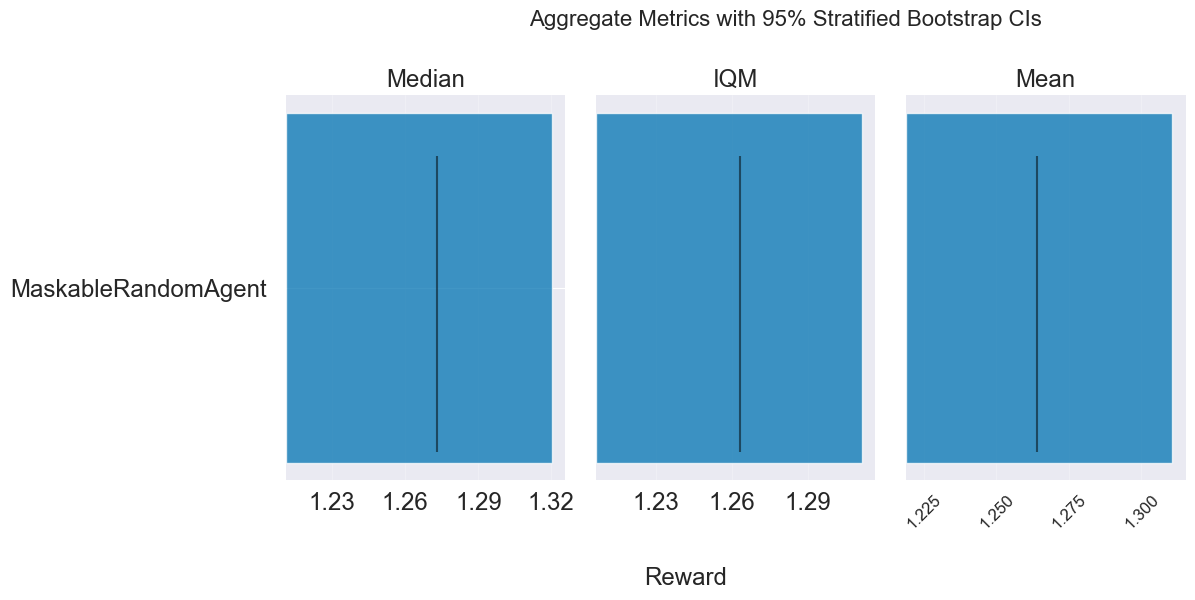

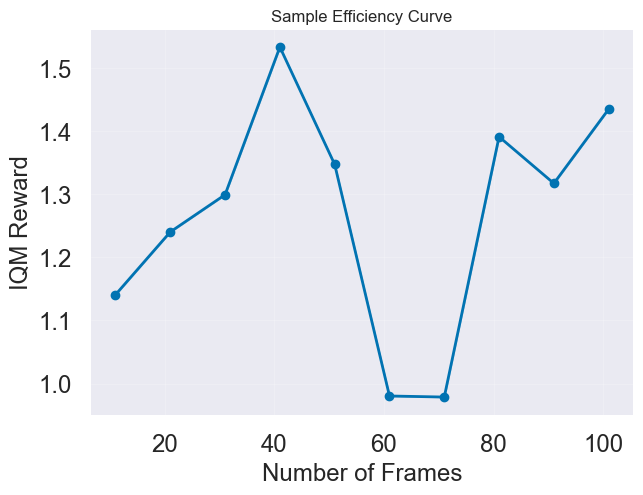

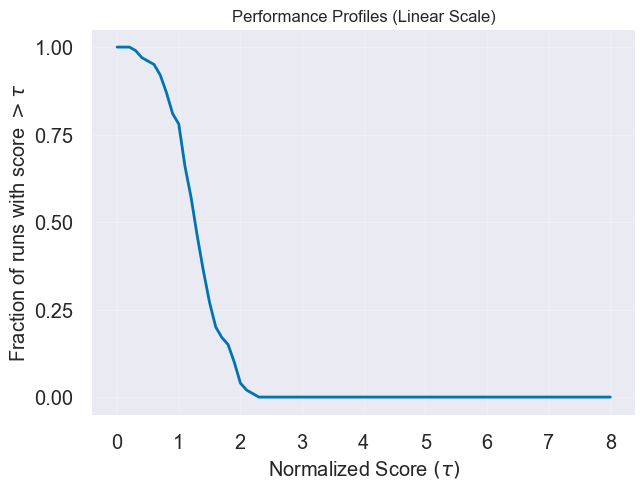

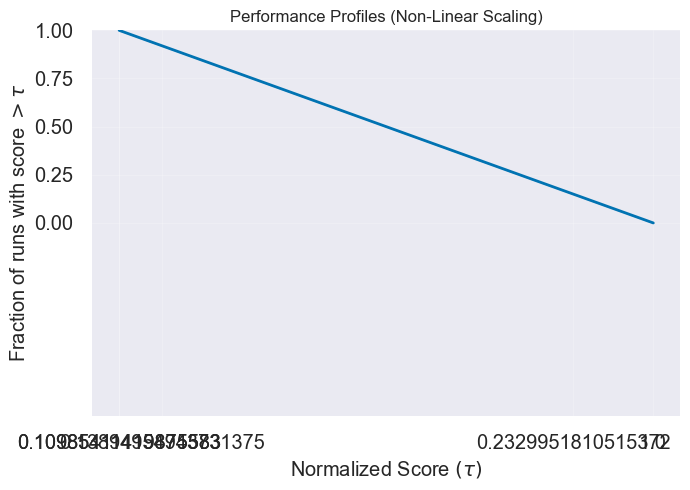

In [ ]:
#| export
plot_evaluation_results(results)

In [ ]:
    #| export
results["QRDQNAgent_Baseline"] = qrdqn_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)


Running experiment with seed 123456...
  Training for 10 timesteps...
  Training for 20 timesteps...
  Training for 30 timesteps...
  Training for 40 timesteps...
  Training for 50 timesteps...
  Training for 60 timesteps...
  Training for 70 timesteps...
  Training for 80 timesteps...
  Training for 90 timesteps...
  Training for 100 timesteps...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-101.       -101.       -101.       -101.       -101.
   -101.       -101.       -101.       -101.       -101.      ]
  [ -99.849866 -101.       -101.       -101.       -101.
   -101.       -101.       -101.       -101.       -101.      ]
  [-101.       -101.       -101.       -101.       -101.
   -101.       -101.       -101.       -101.       -101.      ]
  [-101.       -101.       -101.       -101.       -101.
   -101.       -101.       -101.       -101.       -101.      ]
  [ -97.673423  -96.665467  -96.699681  -98.740722  -96.656334
    -96.732068  -96.676758  -99.869352  -

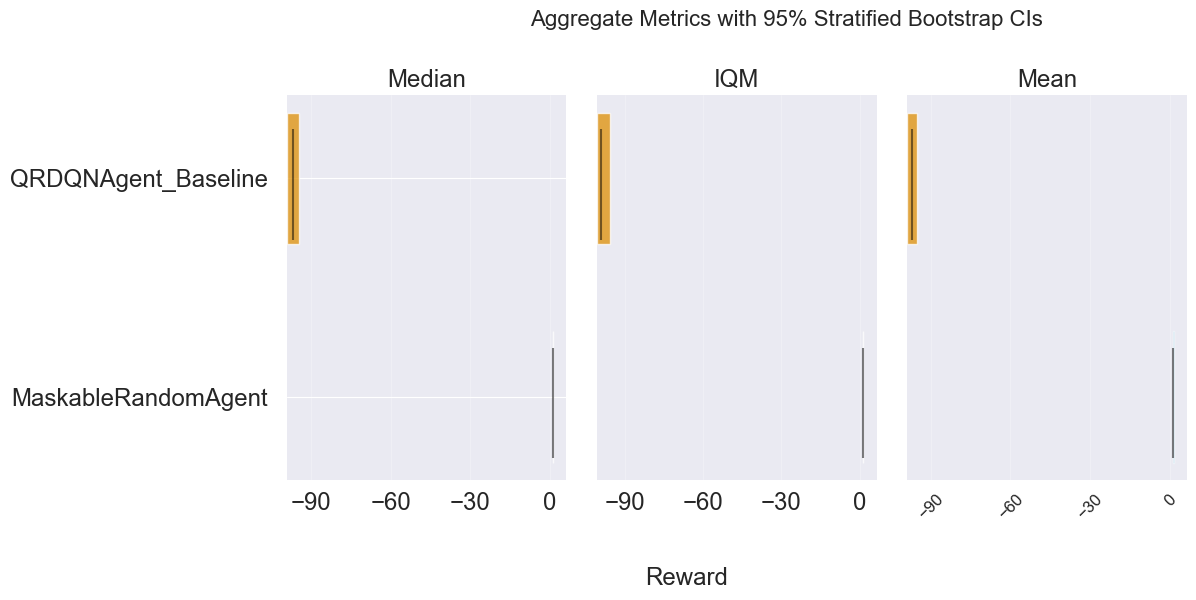

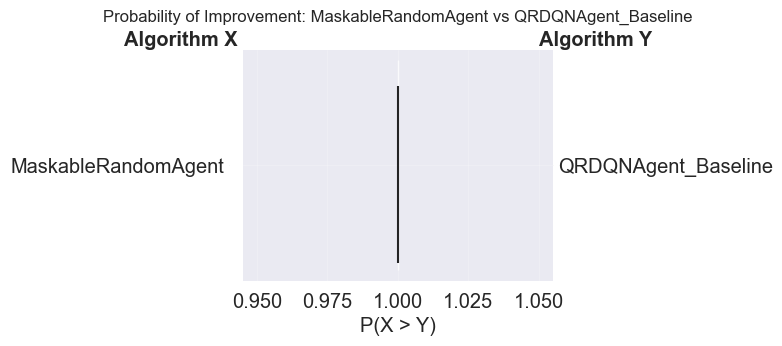

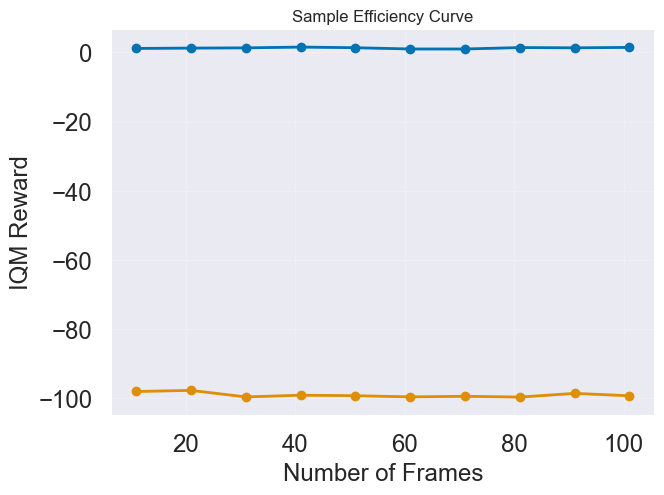

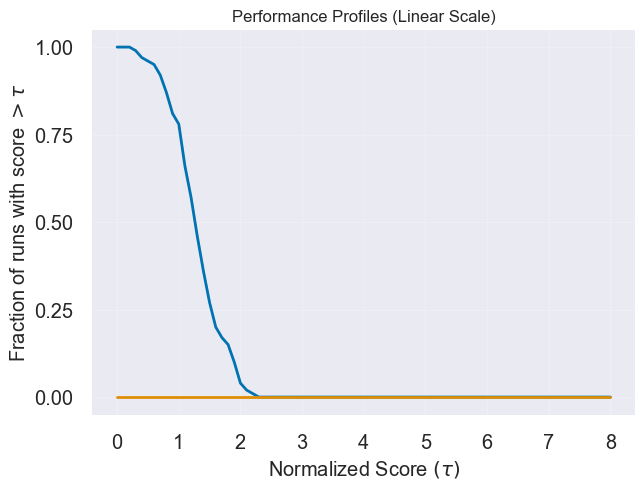

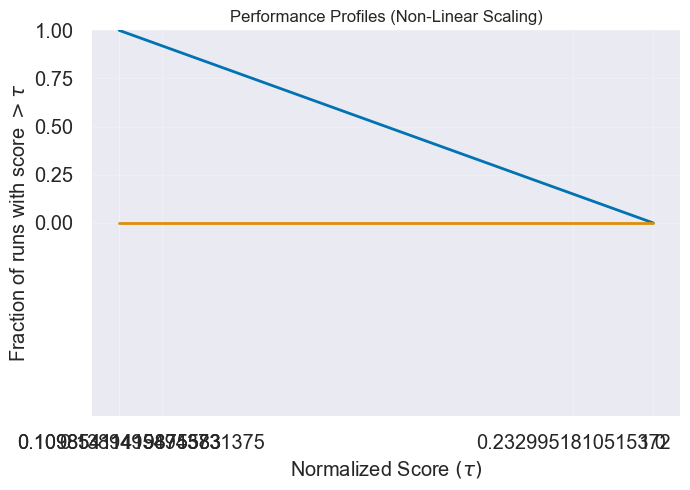

In [ ]:
#| export
plot_evaluation_results(results)

### Evaluation MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPOAgent_Baseline"] = maskable_ppo_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)


Running experiment with seed 123456...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-1.046221 -1.016198 -0.599246 -1.06543  -1.027055 -0.994929 -1.283508
   -0.757123 -1.087682 -0.902379]
  [-0.685305 -0.992507 -1.221335 -0.834737 -1.205643 -0.632132 -1.121343
   -0.924511 -1.212094 -1.280054]
  [ 1.688894  2.640157  2.380083  2.545358  3.101288  1.044661  2.669412
    1.772653  2.791837  2.136413]
  [ 3.013263  3.334121  4.746792  3.952503  3.667153  3.386997  3.609501
    3.986408  3.99462   4.512722]
  [ 2.920276  3.193711  4.373889  3.127643  2.485679  2.385196  3.540524
    3.26697   2.481675  3.145489]
  [ 0.078141 -0.2429   -0.678441 -0.221338 -0.280256 -1.19572  -0.646613
   -0.615193 -0.343361 -0.567747]
  [-0.20599  -0.02569   0.233512  0.249903 -0.269939  0.18974   0.487187
   -0.389208 -1.019556  0.75652 ]
  [-1.186866 -0.376745 -0.494587 -0.643942 -0.674098 -0.954127 -1.3699
   -0.802625 -0.649565 -1.017725]
  [ 0.879127  1.219854  0.675676  0.490119  0

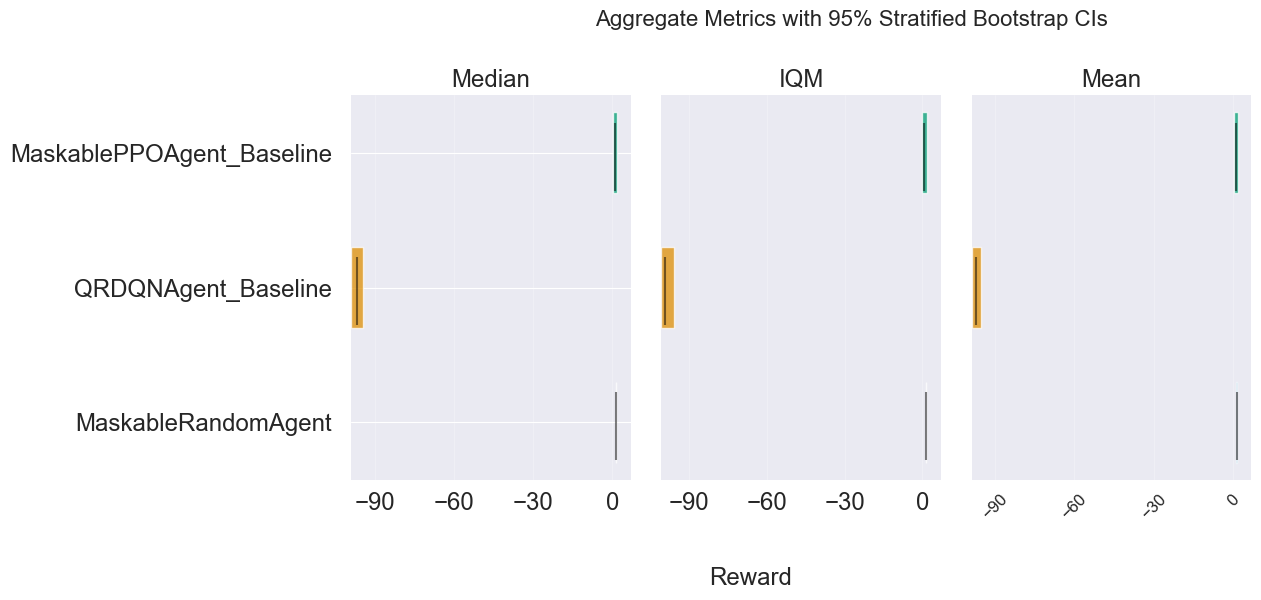

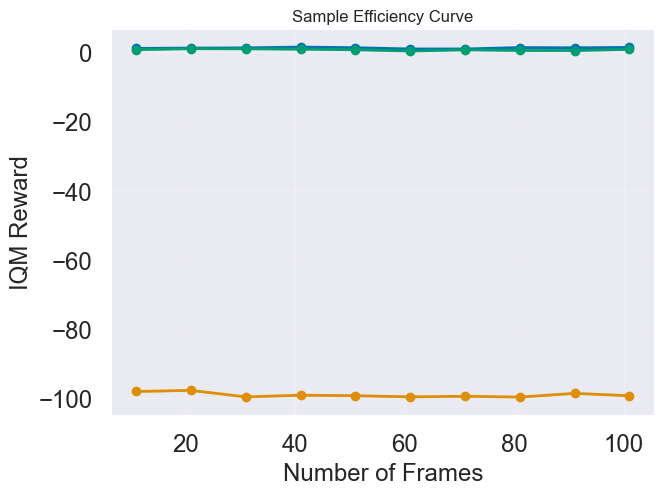

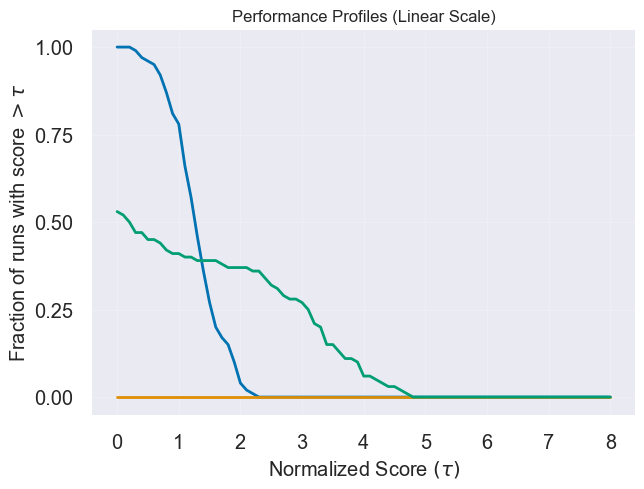

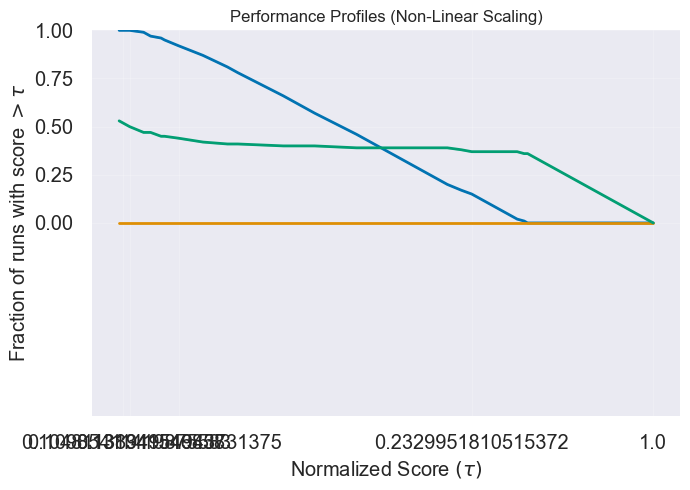

In [ ]:
#| export
plot_evaluation_results(results)

### Hypertuning MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(maskable_ppo_agent.optimize_agent, n_trials=N_TRAILS, n_jobs=N_JOBS)

print("Best trial:", study.best_trial)

[I 2025-02-21 23:02:34,767] A new study created in memory with name: no-name-32ad5e42-0af5-4eeb-bd60-26a5c5541a65
[I 2025-02-21 23:02:41,891] Trial 4 finished with value: -0.10652000000000002 and parameters: {'learning_rate': 0.00013446094682850585, 'n_steps': 52, 'batch_size': 93, 'gamma': 0.9830877507349415, 'gae_lambda': 0.9500683249495147, 'ent_coef': 0.016675218267693814, 'vf_coef': 0.5788485171351725, 'clip_range': 0.15453404809490917, 'max_grad_norm': 0.14365295354067054}. Best is trial 4 with value: -0.10652000000000002.
[I 2025-02-21 23:02:43,062] Trial 0 finished with value: 1.4157654999999998 and parameters: {'learning_rate': 8.123307848735644e-05, 'n_steps': 117, 'batch_size': 28, 'gamma': 0.9140298081903749, 'gae_lambda': 0.9960126016023523, 'ent_coef': 0.007609280246454589, 'vf_coef': 0.1868157204761865, 'clip_range': 0.21403943925413213, 'max_grad_norm': 0.2992808674231695}. Best is trial 0 with value: 1.4157654999999998.
[I 2025-02-21 23:02:43,365] Trial 2 finished with

Best trial: FrozenTrial(number=7, state=1, values=[1.9827472], datetime_start=datetime.datetime(2025, 2, 21, 23, 2, 41, 895276), datetime_complete=datetime.datetime(2025, 2, 21, 23, 2, 49, 478474), params={'learning_rate': 9.202834345732537e-05, 'n_steps': 585, 'batch_size': 145, 'gamma': 0.9526167504923979, 'gae_lambda': 0.8813939567205425, 'ent_coef': 0.014400511428945991, 'vf_coef': 0.5690115431996151, 'clip_range': 0.29923511018920623, 'max_grad_norm': 0.12712439498107478}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'n_steps': IntDistribution(high=1024, log=True, low=32, step=1), 'batch_size': IntDistribution(high=256, log=True, low=16, step=1), 'gamma': FloatDistribution(high=0.9999, log=False, low=0.9, step=None), 'gae_lambda': FloatDistribution(high=1.0, log=False, low=0.8, step=None), 'ent_coef': FloatDistribution(high=0.02, log=False, low=0.0, step=None), 'vf_coef': Floa

### Evaluation MaskablePPO with optimized hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPOAgent_Optimized"] = maskable_ppo_agent.evaluate_policy(hyperparameters=study.best_trial.params, n_episodes=N_EPISODES, render=False)


Running experiment with seed 123456...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[ 1.249796  1.213806  1.725594  0.119639  1.084774  2.052122  1.723086
    1.804573  1.197126  1.325655]
  [-0.995216 -0.77213  -0.916867 -0.797994 -0.995142 -0.657311 -0.789983
   -0.706185 -0.752427 -0.761198]
  [-1.018661 -0.759189 -0.839345 -1.051852 -0.815945 -0.835663 -1.502901
   -1.24694  -1.43462  -0.935699]
  [ 3.555935  4.195566  3.092983  2.958429  2.277281  3.703471  3.020098
    3.557252  3.345705  3.665839]
  [ 3.254637  3.031359  3.029741  3.046975  3.039642  3.393725  2.563987
    3.920593  3.131533  2.823537]
  [ 2.603405  4.290431  3.54059   3.555271  3.41802   3.132108  2.729162
    3.266295  4.513226  4.170647]
  [ 4.335674  4.769318  3.843743  4.128268  4.23569   3.863631  3.655835
    3.57409   4.571215  4.222757]
  [ 0.84754   2.819496  0.602403  1.538661  1.286592  1.685974  1.696503
    1.575371  0.894134  1.408151]
  [ 1.714327  1.775889  1.923944  2.936495 

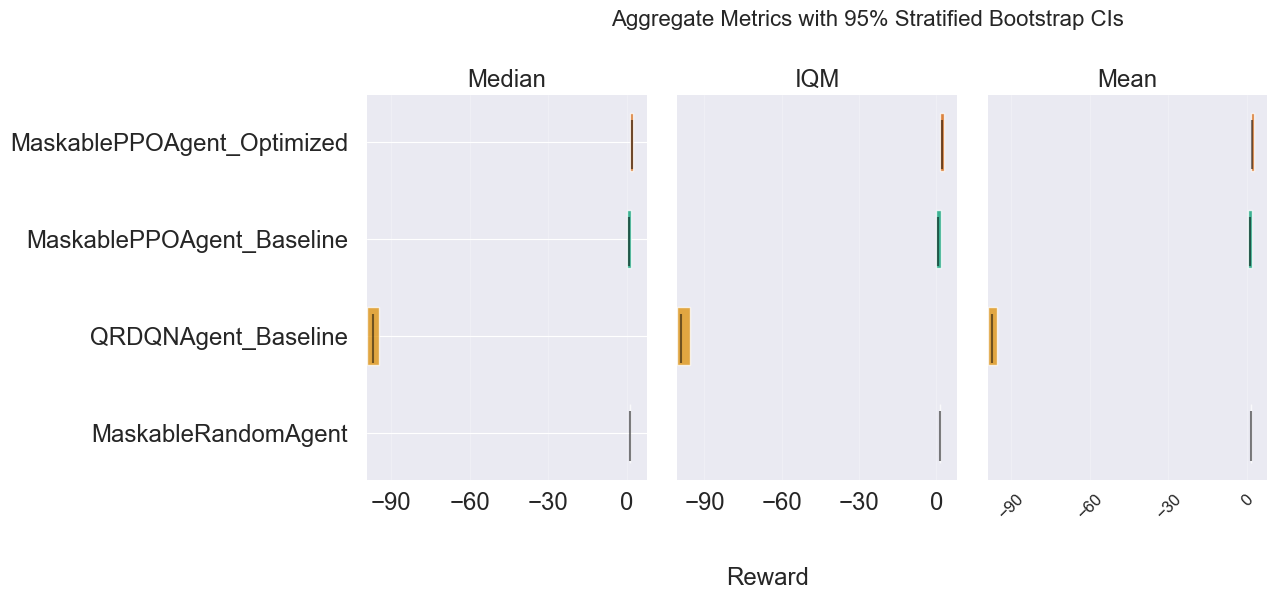

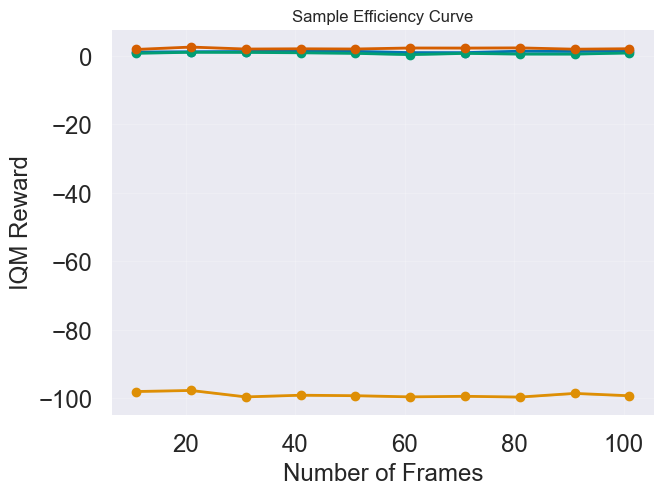

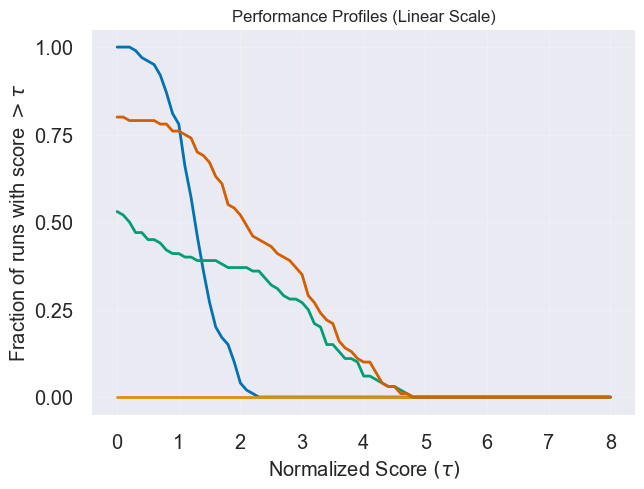

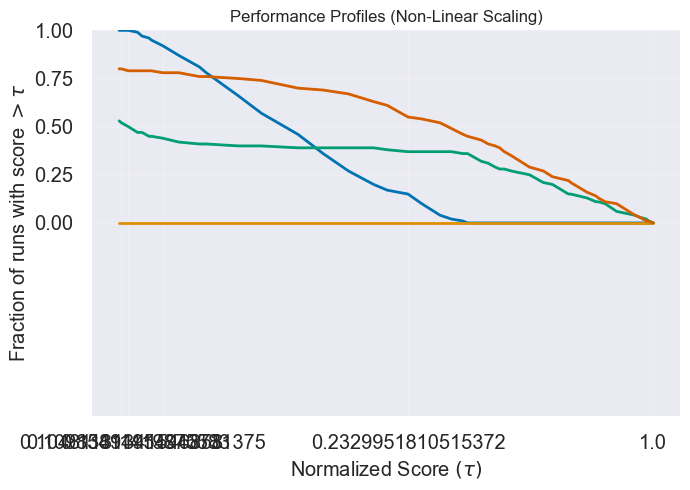

In [ ]:
#| export
plot_evaluation_results(results)

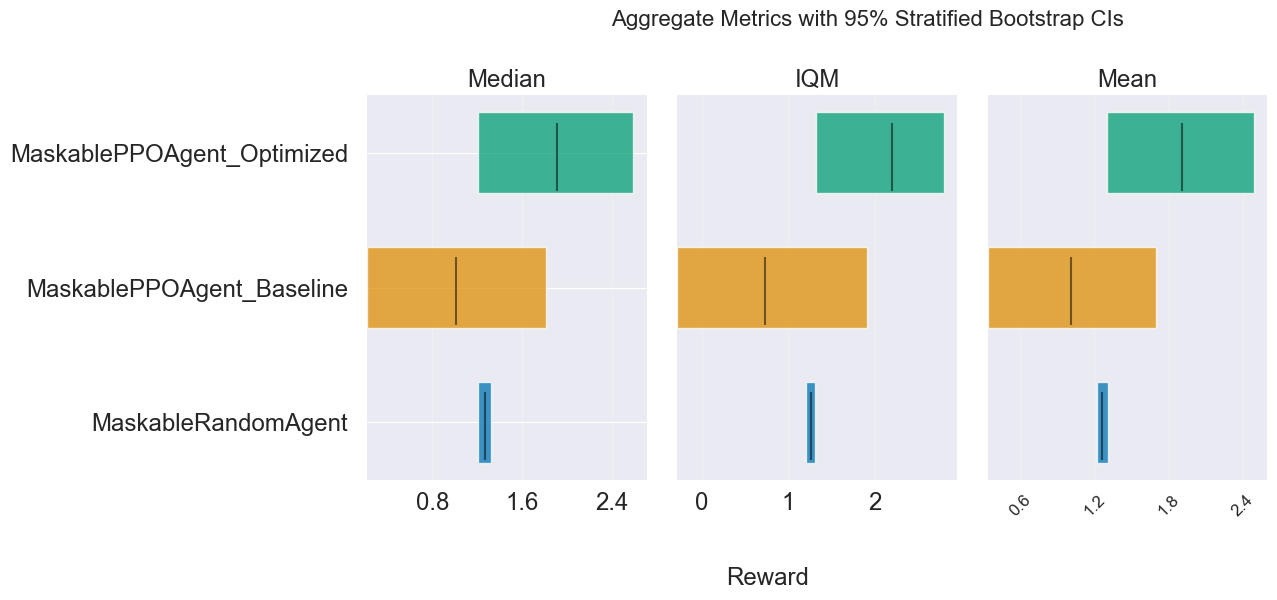

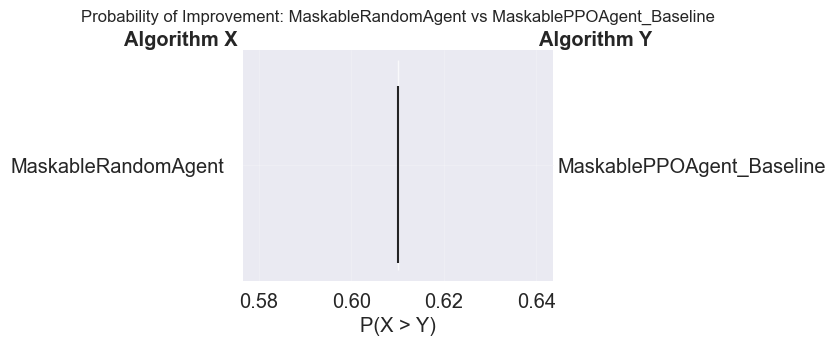

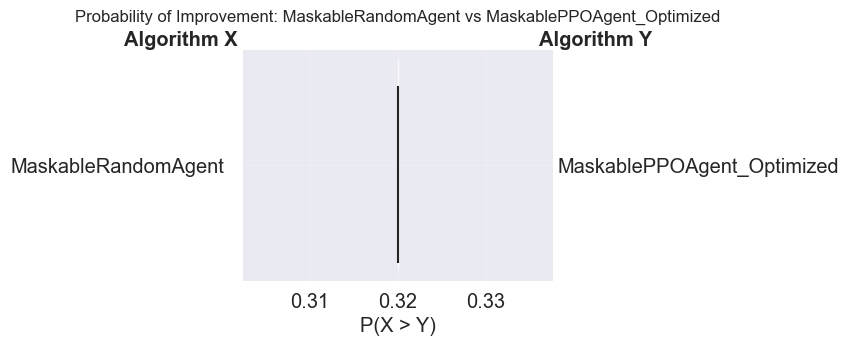

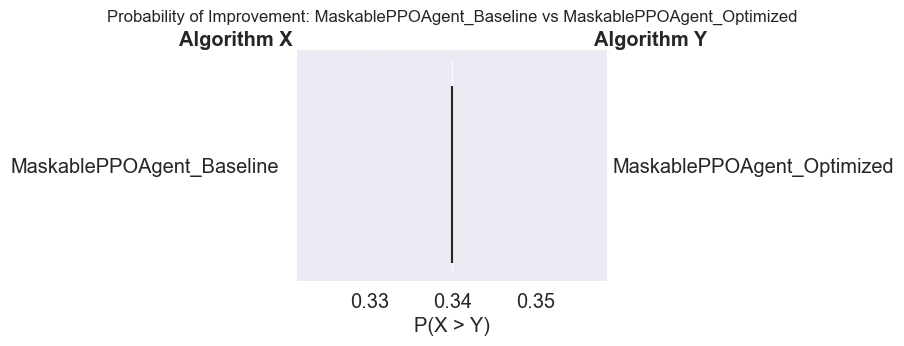

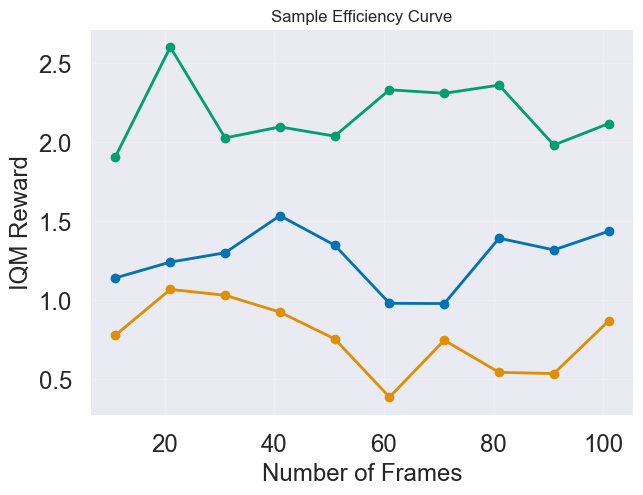

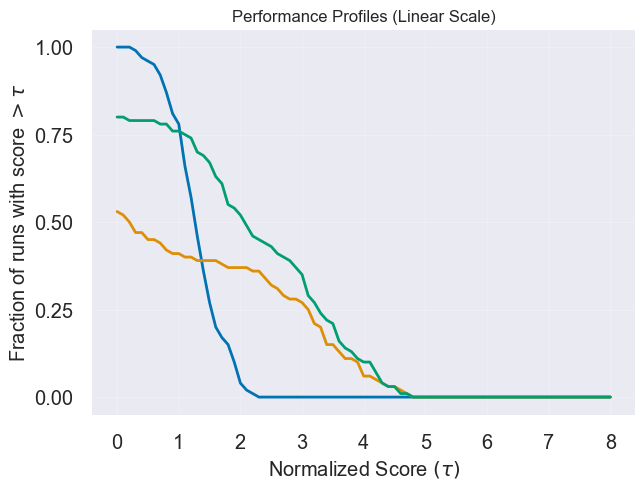

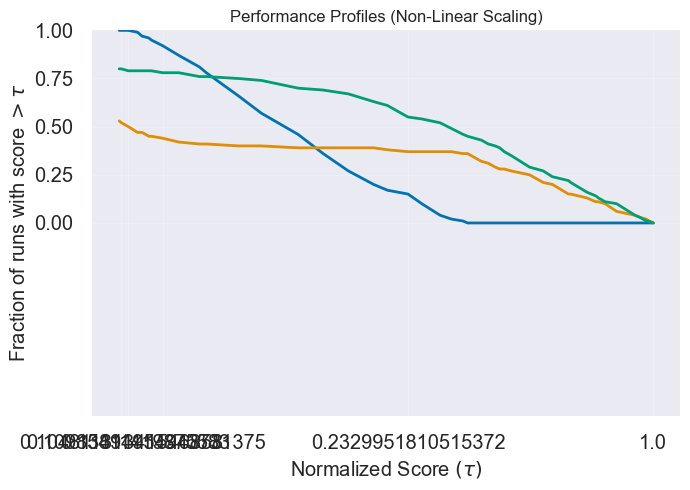

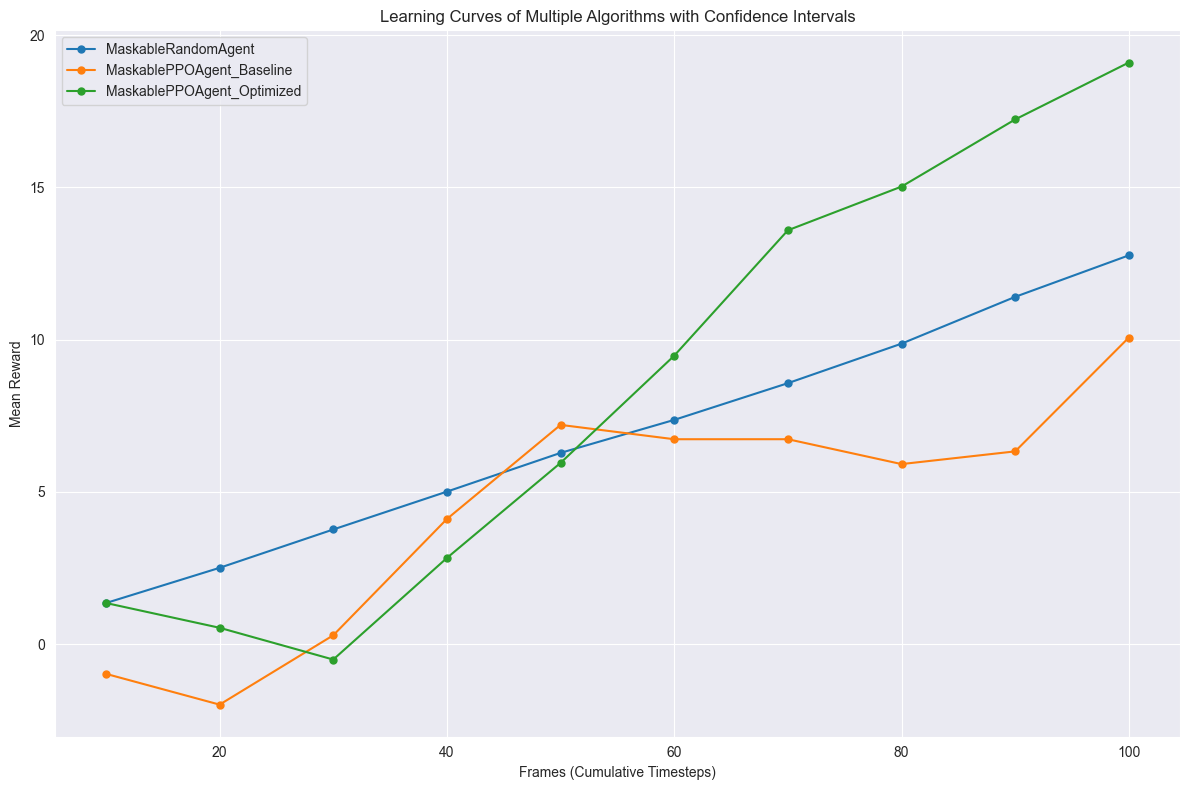

In [ ]:
#| hide
results_2 = results.copy()
results_2.pop("QRDQNAgent_Baseline")
plot_evaluation_results(results_2)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()